<a href="https://colab.research.google.com/github/simon-m-mudd/random_fun_notebooks/blob/main/fit_file_viz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install fitparse pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fitparse: filename=fitparse-1.2.0-py3-none-any.whl size=68214 sha256=cb7c484427a91ee7d55832fa0123b698fedd95031297e45e8b9271ab876e4314
  Stored in directory: /root/.cache/pip/wheels/70/74/f4/07ba357f689c8c76c09a5c6c399831b0cb3452dcc7703f304c
Successfully built fitparse


In [13]:
import os
import fitparse
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np

def find_fit_files(directory):
    """
    Searches the specified directory for all files with the .fit extension and returns a list of their filenames.

    Parameters:
    directory (str): The directory to search for .fit files.

    Returns:
    list: A list of filenames with the .fit extension.
    """
    fit_files = [f for f in os.listdir(directory) if f.endswith('.fit')]
    return fit_files


def read_fit_file(file_path):
    """
    Reads a .fit file and returns a DataFrame with the relevant data.

    Parameters:
    file_path (str): The path to the .fit file.

    Returns:
    pd.DataFrame: DataFrame containing the relevant data.
    """
    fitfile = FitFile(file_path)
    data = []

    for record in fitfile.get_messages('record'):
        record_data = {}
        for data_point in record:
            record_data[data_point.name] = data_point.value
        data.append(record_data)

    df = pd.DataFrame(data)
    df['elapsed_time'] = (df['timestamp'] - df['timestamp'][0]).dt.total_seconds() / 60.0
    return df[['elapsed_time', 'heart_rate', 'cadence', 'power', 'altitude']]



def moving_window_avg_power_backward(df: pd.DataFrame,
                                     window_seconds: int) -> pd.DataFrame:
    """
    Backward-looking (right-aligned) time-based moving average of power.
    The average at time t is over (t - window, t], and is reported at t.
    """
    if not {'elapsed_time', 'power'}.issubset(df.columns):
        raise ValueError("DataFrame must contain 'elapsed_time' (minutes) and 'power' (W).")

    work = df[['elapsed_time', 'power']].copy()
    work['elapsed_s'] = work['elapsed_time'] * 60.0

    # TimedeltaIndex for time-based rolling
    idx = pd.to_timedelta(work['elapsed_s'], unit='s')
    s_power = pd.Series(work['power'].astype(float).values, index=idx)

    # Right-aligned rolling mean; label is at the RIGHT edge (no shifting!)
    avg = s_power.rolling(f'{window_seconds}s', closed='right').mean()

    avg_df = (
        pd.DataFrame({'elapsed_s': avg.index.total_seconds(), 'avg_power': avg.values})
        .dropna()
        .sort_values('elapsed_s')
        .reset_index(drop=True)
    )
    return avg_df


def find_local_peaks(avg_df: pd.DataFrame,
                     min_distance_seconds: float = 0.0,
                     min_prominence_watts: float = 0.0,
                     sort_by: str = "time") -> pd.DataFrame:
    """
    Peak finding using scipy.signal.find_peaks on the SAME avg_df that is plotted.
    """
    required = {'elapsed_s', 'avg_power'}
    if not required.issubset(avg_df.columns) or avg_df.empty:
        return pd.DataFrame(columns=['elapsed_s', 'avg_power'])

    t = avg_df['elapsed_s'].to_numpy()
    y = avg_df['avg_power'].to_numpy(dtype=float)

    mask = np.isfinite(t) & np.isfinite(y)
    if mask.sum() < 3:
        return pd.DataFrame(columns=['elapsed_s', 'avg_power'])
    t = t[mask]
    y = y[mask]

    # Convert seconds to samples using median dt
    dt = np.median(np.diff(t)) if len(t) >= 2 else 1.0
    dt = dt if dt > 0 else 1.0
    distance_samples = None
    if min_distance_seconds and min_distance_seconds > 0:
        distance_samples = max(int(round(min_distance_seconds / dt)), 1)

    peaks_idx, _ = find_peaks(
        y,
        distance=distance_samples,
        prominence=(min_prominence_watts if (min_prominence_watts and min_prominence_watts > 0) else None)
    )

    if peaks_idx.size == 0:
        return pd.DataFrame(columns=['elapsed_s', 'avg_power'])

    peaks_df = pd.DataFrame({'elapsed_s': t[peaks_idx], 'avg_power': y[peaks_idx]})
    if sort_by == "power":
        peaks_df = peaks_df.sort_values('avg_power', ascending=False, kind='mergesort')
    else:
        peaks_df = peaks_df.sort_values('elapsed_s', ascending=True, kind='mergesort')
    return peaks_df.reset_index(drop=True)


def plot_avg_power_with_altitude(avg_df: pd.DataFrame,
                                 raw_df: pd.DataFrame | None = None,
                                 peaks_df: pd.DataFrame | None = None,
                                 window_seconds: int = 0,
                                 altitude_alpha: float = 0.25,
                                 altitude_color: str = 'tab:green',
                                 show_peak_lines: bool = True) -> None:
    """
    Plot moving-average power vs time, with altitude as a semi-transparent filled background.
    """
    fig, ax_power = plt.subplots(figsize=(12, 5))

    # Optional raw power in the background
    if raw_df is not None and {'elapsed_time', 'power'}.issubset(raw_df.columns):
        ax_power.plot(raw_df['elapsed_time'], raw_df['power'],
                      color='gray', alpha=0.25, linewidth=1.0, label='Raw power')

    # Moving-average power (primary axis)
    ax_power.plot(avg_df['elapsed_s'] / 60.0, avg_df['avg_power'],
                  color='C0', linewidth=2.0, label=f'Moving avg ({window_seconds}s)')

    # Peaks
    if peaks_df is not None and not peaks_df.empty:
        peak_t_min = peaks_df['elapsed_s'] / 60.0
        ax_power.scatter(peak_t_min, peaks_df['avg_power'],
                         color='C3', s=36, zorder=3, label='Local peaks')
        if show_peak_lines:
            for x in peak_t_min:
                ax_power.axvline(x=x, color='C3', alpha=0.25, linewidth=1.0)

    ax_power.set_xlabel('Time (min)')
    ax_power.set_ylabel('Power (W)', color='C0')
    ax_power.tick_params(axis='y', labelcolor='C0')
    ax_power.grid(True, alpha=0.3)

    # Altitude filled background (secondary axis)
    if raw_df is not None and {'elapsed_time', 'altitude'}.issubset(raw_df.columns):
        ax_alt = ax_power.twinx()
        time_min = pd.to_numeric(raw_df['elapsed_time'], errors='coerce').to_numpy()
        alt = pd.to_numeric(raw_df['altitude'], errors='coerce').to_numpy()
        ok = np.isfinite(time_min) & np.isfinite(alt)
        if ok.any():
            # Fill to the min altitude (visually “from ground”)
            baseline = np.nanmin(alt[ok])
            ax_alt.fill_between(time_min[ok], alt[ok], y2=baseline,
                                color=altitude_color, alpha=altitude_alpha, label='Altitude')
            ax_alt.set_ylabel('Altitude (m)', color=altitude_color)
            ax_alt.tick_params(axis='y', labelcolor=altitude_color)
            ax_alt.grid(False)

            # Merge legends
            h1, l1 = ax_power.get_legend_handles_labels()
            h2, l2 = ax_alt.get_legend_handles_labels()
            ax_power.legend(h1 + h2, l1 + l2, loc='upper right')
        else:
            ax_power.legend(loc='upper right')
    else:
        ax_power.legend(loc='upper right')

    title = 'Average Power vs Time'
    if window_seconds > 0:
        title += f' (backward-looking {window_seconds}s)'
    ax_power.set_title(title)

    fig.tight_layout()
    plt.show()




def plot_activity(df):
    """
    Plots the activity data with separate vertical axes for heart rate, cadence, and power, and a filled plot for altitude.

    Parameters:
    df (pd.DataFrame): DataFrame containing the activity data.
    """
    fig, ax1 = plt.subplots(figsize=(16, 8))

    ax1.set_xlabel('Elapsed Time (minutes)', fontsize=24)
    ax1.set_ylabel('Heart Rate (bpm)', color='red', fontsize=24)
    ax1.plot(df['elapsed_time'], df['heart_rate'], color='red', label='Heart Rate')
    ax1.tick_params(axis='y', labelcolor='red', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)

    ax2 = ax1.twinx()
    ax2.set_ylabel('Cadence (rpm)', color='blue', fontsize=24)
    ax2.plot(df['elapsed_time'], df['cadence'], color='blue', label='Cadence')
    ax2.tick_params(axis='y', labelcolor='blue', labelsize=20)

    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    ax3.set_ylabel('Power (watts)', color='black', fontsize=24)
    ax3.plot(df['elapsed_time'], df['power'], color='black', label='Power')
    ax3.tick_params(axis='y', labelcolor='black', labelsize=20)

    fig.tight_layout()
    plt.title('Activity Data', fontsize=28)
    plt.show()

    fig, ax = plt.subplots(figsize=(16, 8))
    ax.fill_between(df['elapsed_time'], df['altitude'], color='green', alpha=0.9)
    ax.set_xlabel('Elapsed Time (minutes)', fontsize=24)
    ax.set_ylabel('Altitude (meters)', fontsize=24)
    ax.set_ylim(df['altitude'].min(), df['altitude'].max())
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    plt.title('Altitude Data', fontsize=28)
    plt.show()

def plot_activity_with_range(df, min_time, max_time):
    """
    Plots the activity data within a specified time range with separate vertical axes for heart rate, cadence, and power, and a filled plot for altitude.

    Parameters:
    df (pd.DataFrame): DataFrame containing the activity data.
    min_time (float): Minimum elapsed time in minutes.
    max_time (float): Maximum elapsed time in minutes.
    """
    df_range = df[(df['elapsed_time'] >= min_time) & (df['elapsed_time'] <= max_time)]

    mean_power = df_range['power'].mean()
    median_power = df_range['power'].median()
    mean_cadence = df_range['cadence'].mean()
    median_cadence = df_range['cadence'].median()

    fig, ax1 = plt.subplots(figsize=(16, 8))

    ax1.set_xlabel('Elapsed Time (minutes)', fontsize=24)
    ax1.set_ylabel('Heart Rate (bpm)', color='red', fontsize=24)
    ax1.plot(df_range['elapsed_time'], df_range['heart_rate'], color='red', label='Heart Rate')
    ax1.tick_params(axis='y', labelcolor='red', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)

    ax2 = ax1.twinx()
    ax2.set_ylabel('Cadence (rpm)', color='blue', fontsize=24)
    ax2.plot(df_range['elapsed_time'], df_range['cadence'], color='blue', label='Cadence')
    ax2.tick_params(axis='y', labelcolor='blue', labelsize=20)

    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    ax3.set_ylabel('Power (watts)', color='black', fontsize=24)
    ax3.plot(df_range['elapsed_time'], df_range['power'], color='black', label='Power')
    ax3.tick_params(axis='y', labelcolor='black', labelsize=20)

    fig.tight_layout()
    plt.title('Activity Data', fontsize=28)
    plt.text(0.5, 1.05, f'Mean Power: {mean_power:.2f} W, Median Power: {median_power:.2f} W, Mean Cadence: {mean_cadence:.2f} rpm, Median Cadence: {median_cadence:.2f} rpm',
             transform=ax1.transAxes, fontsize=24, ha='center')
    plt.show()

    fig, ax = plt.subplots(figsize=(16, 8))
    ax.fill_between(df_range['elapsed_time'], df_range['altitude'], color='green', alpha=0.9)
    ax.set_xlabel('Elapsed Time (minutes)', fontsize=24)
    ax.set_ylabel('Altitude (meters)', fontsize=24)
    ax.set_ylim(df['altitude'].min(), df['altitude'].max())
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    plt.title('Altitude Data', fontsize=28)
    plt.show()



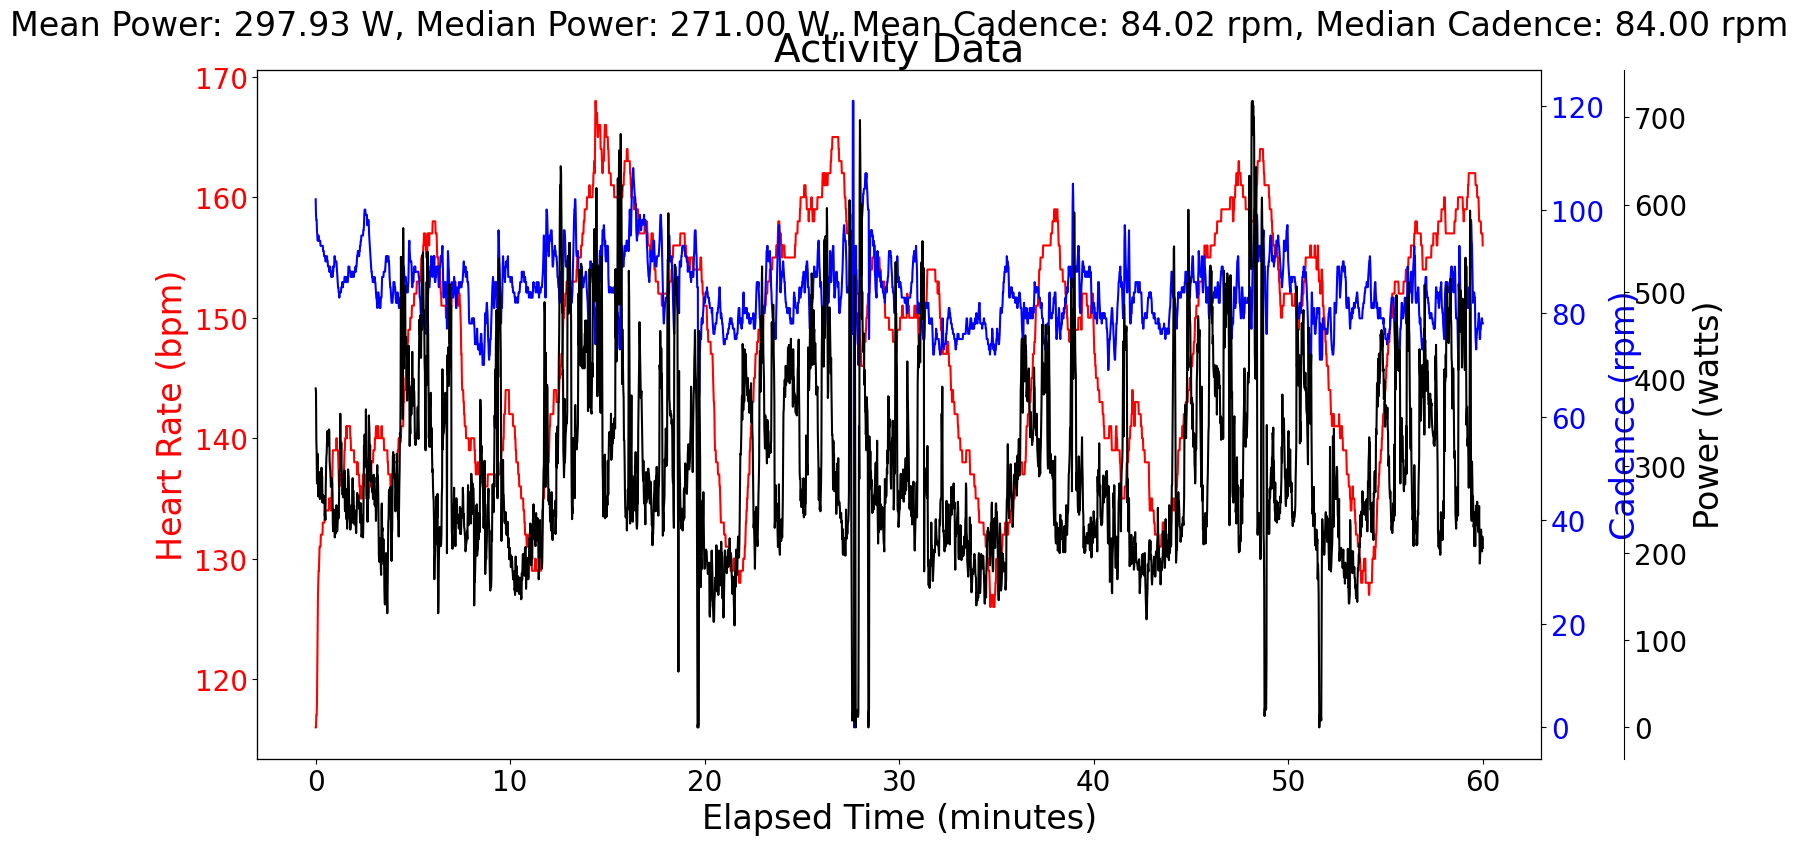

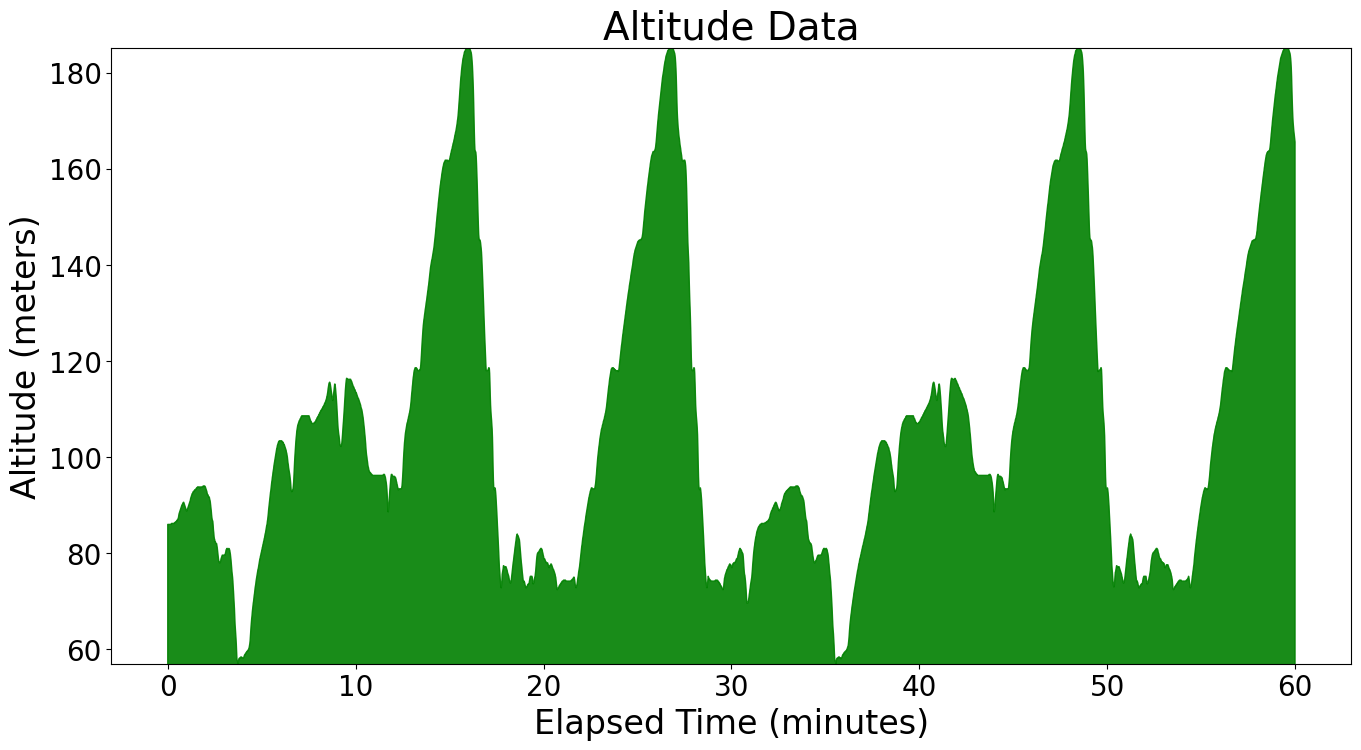

In [5]:

# Example usage
fit_files = find_fit_files('.')  # Searches the current directory
if fit_files:
    df = read_fit_file(fit_files[0])  # Reads the first .fit file found
    #plot_activity(df)
    plot_activity_with_range(df, min_time=0, max_time=60)
else:
    print("No .fit files found in the directory.")

# Example usage:
# df = read_fit_file('your_file.fit')
# plot_activity(df)
# plot_activity_with_range(df, min_time=10, max_time=30)


 elapsed_s  avg_power
      45.0      294.5
     419.0      315.4
    1004.0      380.0
    1609.0      359.1
    1975.0      291.6
    2433.0      302.7
    2925.0      364.9
    3055.0      354.8
    3563.0      357.5


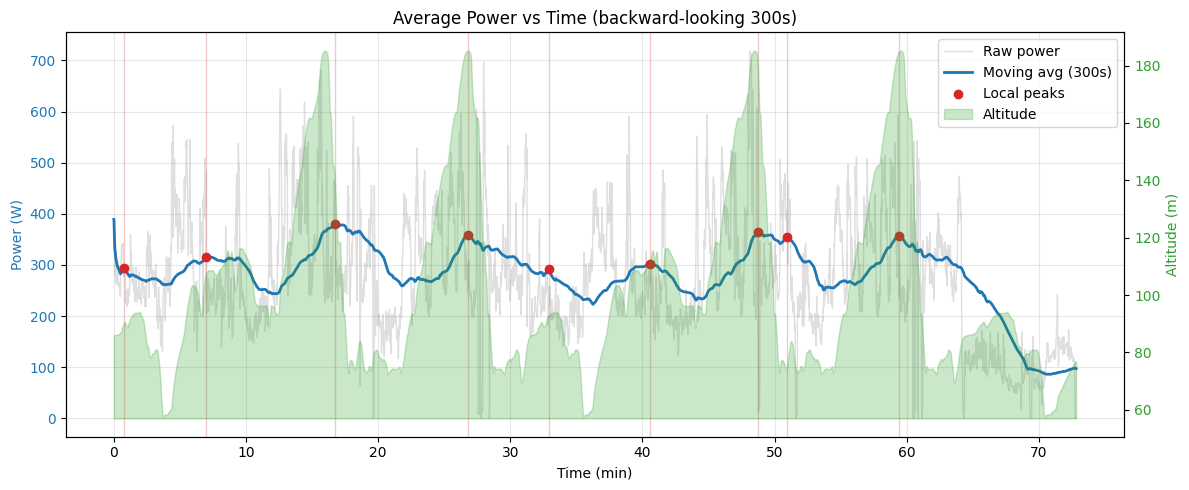

In [20]:
# Example usage
fit_files = find_fit_files('.')  # Searches the current directory
if fit_files:
    df = read_fit_file(fit_files[0])  # Reads the first .fit file found
    avg_df = moving_window_avg_power_backward(df, window_seconds=300)
    peaks_df = find_local_peaks(avg_df,
                                min_distance_seconds=10,     # e.g., keep peaks at least 10s apart
                                min_prominence_watts=10,     # e.g., at least 10 W prominence
                                sort_by="time")              # or "power

    print(peaks_df.round({'elapsed_s': 1, 'avg_power': 1}).to_string(index=False))
    plot_avg_power_with_altitude(avg_df, peaks_df=peaks_df, raw_df=df, window_seconds=300)
else:
    print("No .fit files found in the directory.")
